In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, Subset
from torch.nn import functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd

import cv2
import os
from copy import deepcopy
from collections import Counter


In [2]:
# Dataset
class ConcatenatedDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        transform_positives=None,
        transform_background=None,
        target_transform=None,
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform_positives = transform_positives
        self.transform_background = transform_background
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if label == 0 and self.transform_background:
            image = self.transform_background(image=image)["image"]
        if label != 0 and self.transform_positives:
            image = self.transform_positives(image=image)["image"]

        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [3]:
dataset = ConcatenatedDataset(
    annotations_file="imgs_merged/labels.csv",
    img_dir="imgs_merged",
)


In [4]:
# Split
df = dataset.img_labels
train_all_ind, test_ind = train_test_split(df, stratify=df[1], test_size=0.8)
train_df = df.iloc[train_all_ind.index]
train_ind, val_ind = train_test_split(train_df, stratify=train_df[1], test_size=0.3)

val_dataset = Subset(dataset=dataset, indices=val_ind.index.to_numpy())
test_dataset = Subset(dataset=dataset, indices=test_ind.index.to_numpy())
train_dataset = deepcopy(Subset(dataset=dataset, indices=train_ind.index.to_numpy()))


In [5]:
# transforms
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
train_transform = A.Compose(
    [
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        A.Rotate(limit=60, p=1.0),
        A.ToGray(always_apply=True),
        A.GaussNoise(always_apply=True),
        A.Normalize(),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        A.ToGray(always_apply=True),
        A.Normalize(),
        ToTensorV2(),
    ]
)

train_dataset.dataset.transform_positives = train_transform
train_dataset.dataset.transform_background = train_transform

test_dataset.dataset.transform_positives = test_transform
test_dataset.dataset.transform_background = test_transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Background: 1,
20-sign: 2,
30-sign: 2


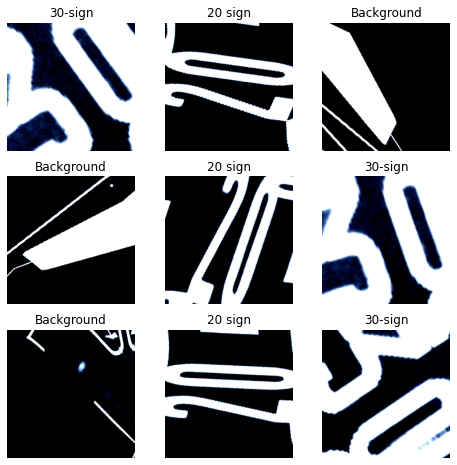

In [6]:
labels_map = {
    0: "Background",
    1: "20 sign",
    2: "30-sign",
}


def img_show(dataset, labels_map):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):

        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0), cmap="gray")

    occurences = Counter([label for img, label in val_dataset])
    print(
        f"Background: {occurences[0]},\n20-sign: {occurences[1]},\n30-sign: {occurences[2]}"
    )
    plt.show()


img_show(train_dataset, labels_map)


In [7]:
# model
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.drop1 = nn.Dropout2d(p=0.5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        self.drop1 = nn.Dropout2d(p=0.5)

        self.fc1 = torch.nn.LazyLinear(120) 
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [8]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        images = images.float()
        optimizer.zero_grad()

        output = model(images)

        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss, train_correct


def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        images = images.float()
        output = model(images)
        loss = loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()

    return valid_loss, val_correct


In [9]:
RandomSampler(train_ind.index.to_numpy())
len(train_ind)


11

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
batch_size = 100


In [11]:
# Loaders
train_sampler = RandomSampler(
    train_dataset, replacement=True, num_samples=len(train_ind) * 10
)
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LeNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)

history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

for epoch in range(num_epochs):
    train_loss, train_correct = train_epoch(
        model, device, train_loader, criterion, optimizer
    )
    test_loss, test_correct = valid_epoch(model, device, val_loader, criterion)

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = test_loss / len(val_loader.sampler)
    test_acc = test_correct / len(val_loader.sampler) * 100

    print(
        "Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
            epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc
        )
    )
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)


/Users/piotr/Documents/studia/SEM6/TWM/road-markings-detection/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch:1/20 AVG Training Loss:1.076 AVG Test Loss:1.026 AVG Training Acc 36.36 % AVG Test Acc 40.00 %
Epoch:2/20 AVG Training Loss:1.499 AVG Test Loss:1.414 AVG Training Acc 26.36 % AVG Test Acc 80.00 %
Epoch:3/20 AVG Training Loss:2.646 AVG Test Loss:0.869 AVG Training Acc 68.18 % AVG Test Acc 80.00 %
Epoch:4/20 AVG Training Loss:0.876 AVG Test Loss:0.310 AVG Training Acc 80.91 % AVG Test Acc 80.00 %
Epoch:5/20 AVG Training Loss:0.932 AVG Test Loss:0.459 AVG Training Acc 72.73 % AVG Test Acc 80.00 %
Epoch:6/20 AVG Training Loss:0.507 AVG Test Loss:0.439 AVG Training Acc 83.64 % AVG Test Acc 60.00 %
Epoch:7/20 AVG Training Loss:0.682 AVG Test Loss:0.167 AVG Training Acc 50.91 % AVG Test Acc 100.00 %
Epoch:8/20 AVG Training Loss:0.295 AVG Test Loss:0.251 AVG Training Acc 96.36 % AVG Test Acc 80.00 %
Epoch:9/20 AVG Training Loss:0.278 AVG Test Loss:0.253 AVG Training Acc 83.64 % AVG Test Acc 80.00 %
Epoch:10/20 AVG Training Loss:0.283 AVG Test Loss:0.217 AVG Training Acc 87.27 % AVG Test 

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images: {100 * correct // total} %")


Accuracy of the network on the test images: 100 %


In [14]:
print("Train: ", len(train_dataset), len(train_dataset) * 10)
print("Val: ", len(val_dataset))
print("Test: ", len(test_dataset))


Train:  11 110
Val:  5
Test:  68


In [15]:
1 / 68 * 100 * 1

1.4705882352941175